## Source:
[1] https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution/log

[2] https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
# from keras import backend as K
color = sns.color_palette()
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical

import sys
import datetime
import time

print("Python version: ", sys.version)
print("Version info.: ", sys.version_info)
print("TensorFlow version: ", tf.__version__)
print("TensorFlow.Keras version : ", tf.keras.__version__)

Python version:  3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 23:13:11) 
[GCC 7.3.0]
Version info.:  sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
TensorFlow version:  2.1.0
TensorFlow.Keras version :  2.2.4-tf


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# from tensorflow.keras import backend as K
# K.tensorflow_backend
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12948431992502843336
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11501635285350620604
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6498214140357518669
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15865817244798548500
physical_device_desc: "device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:05:00.0, compute capability: 6.0"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 159

## Load Data

In [3]:

# Define path to the data directory
data_dir = Path('/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Data/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'


In [4]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,0
1,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,1
2,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,1
3,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,0
4,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,1


1    3875
0    1341
Name: label, dtype: int64


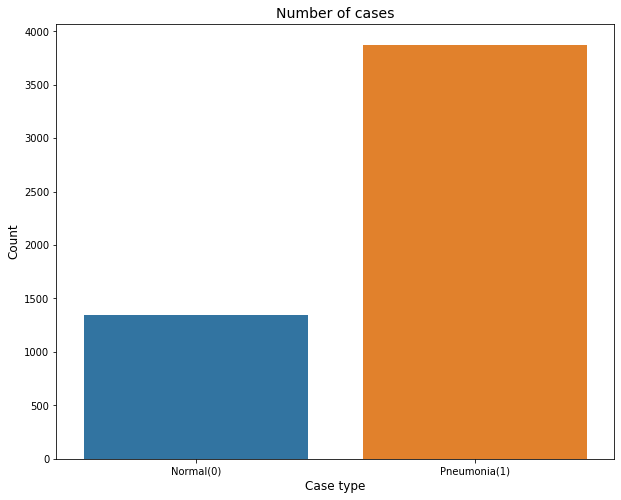

In [5]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

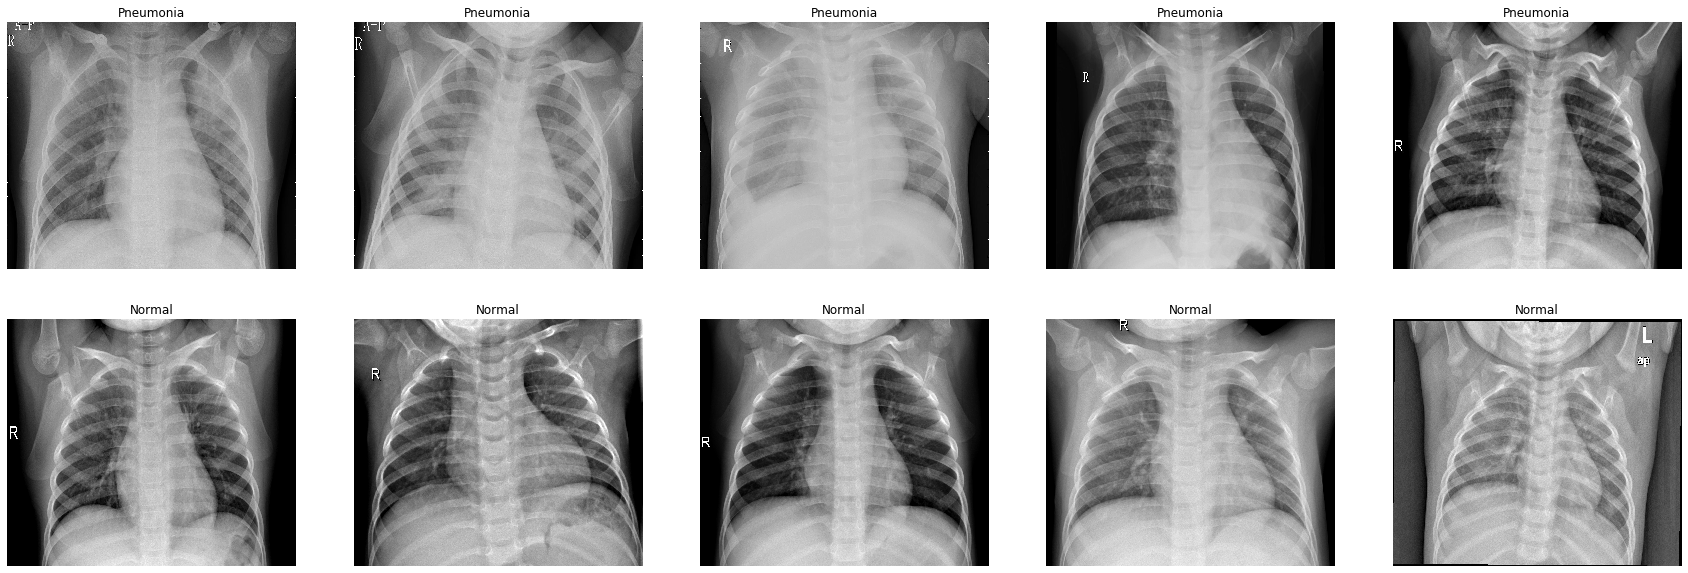

In [6]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [7]:
# # Get the path to the sub-directories
# normal_cases_dir = val_dir / 'NORMAL'
# pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# # Get the list of all the images
# normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# # List that are going to contain validation images data and the corresponding labels
# ori_valid_data = []
# ori_valid_labels = []


# # Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# # We will normalize the pixel values and resizing all the images to 224x224 

# # Normal cases
# for img in normal_cases:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (224,224))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
#     label = to_categorical(0, num_classes=2)
#     ori_valid_data.append(img)
#     ori_valid_labels.append(label)
                      
# # Pneumonia cases        
# for img in pneumonia_cases:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (224,224))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
#     label = to_categorical(1, num_classes=2)
#     ori_valid_data.append(img)
#     ori_valid_labels.append(label)
    
# # Convert the list into numpy arrays
# ori_valid_data = np.array(ori_valid_data)
# ori_valid_labels = np.array(ori_valid_labels)

# print("Total number of validation examples: ", ori_valid_data.shape)
# print("Total number of labels:", ori_valid_labels.shape)

In [8]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
valid_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    valid_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    valid_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
valid_data = pd.DataFrame(valid_data, columns=['image', 'label'],index=None)

# Shuffle the data 
valid_data = valid_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
valid_data.head()

,image,label
0,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,1
1,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,1
2,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,1
3,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,0
4,/data/user/tr27p/Courses/CS765-DeepLearning/Fi...,0


In [9]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

# Augmentation sequence 
seq_val = iaa.OneOf([
    #iaa.Flipud(), # horizontal flips
    #iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [10]:
def data_gen(data, batch_size, augSeq):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = augSeq.augment_image(img)
                aug_img2 = augSeq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [11]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [12]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [13]:
# Open the VGG16 weight file
f = h5py.File('/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Data/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [14]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='./best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [15]:
batch_size = 16
nb_epochs = 100

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size, augSeq=seq)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [16]:
valid_data_gen = data_gen(data=valid_data, batch_size=batch_size, augSeq=seq_val)
nb_valid_steps = valid_data.shape[0]//batch_size

In [17]:
# valid_data_1 = np.concatenate((valid_data, valid_data), axis=0)
# valid_labels_1 = np.concatenate((valid_labels, valid_labels), axis=0)

In [18]:
# Fit the model
history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=2*nb_train_steps,
                    validation_data=valid_data_gen, validation_steps=3*nb_valid_steps,callbacks=[chkpt])#,
                    #class_weight={0:1.0, 1:0.4})

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 652 steps, validate for 3 steps
Epoch 1/100
652/652 [==============================] - 184s 282ms/step - loss: 0.2684 - accuracy: 0.8764 - val_loss: 1.6325 - val_accuracy: 0.2396
Epoch 2/100
652/652 [==============================] - 145s 223ms/step - loss: 0.0922 - accuracy: 0.9662 - val_loss: 0.3554 - val_accuracy: 0.8333
Epoch 3/100
652/652 [==============================] - 140s 214ms/step - loss: 0.0731 - accuracy: 0.9733 - val_loss: 1.0492 - val_accuracy: 0.7292
Epoch 4/100
652/652 [==============================] - 141s 216ms/step - loss: 0.0482 - accuracy: 0.9820 - val_loss: 1.4114 - val_accuracy: 0.5208
Epoch 5/100
652/652 [==============================] - 141s 217ms/step - loss: 0.0470 - accuracy: 0.9835 - val_loss: 0.6194 - val_accuracy: 0.8125
Epoch 6/100
652/652 [==============================] - 141s 217ms/step - loss: 0.0406 - accuracy: 0.9852 - val_loss: 1.0448 - val_accuracy: 0.6250
Epoch 7/100
652/652 [=====

Epoch 53/100
652/652 [==============================] - 141s 216ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.7969 - val_accuracy: 0.9167
Epoch 54/100
652/652 [==============================] - 141s 216ms/step - loss: 1.0768e-04 - accuracy: 1.0000 - val_loss: 0.3196 - val_accuracy: 0.9375
Epoch 55/100
652/652 [==============================] - 140s 215ms/step - loss: 4.1655e-05 - accuracy: 1.0000 - val_loss: 0.7840 - val_accuracy: 0.9375
Epoch 56/100
652/652 [==============================] - 143s 219ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.7014 - val_accuracy: 0.8542
Epoch 57/100
652/652 [==============================] - 141s 217ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.3060 - val_accuracy: 0.9792
Epoch 58/100
652/652 [==============================] - 142s 218ms/step - loss: 5.6884e-04 - accuracy: 0.9996 - val_loss: 0.5127 - val_accuracy: 0.9583
Epoch 59/100
652/652 [==============================] - 141s 216ms/step - loss: 7.1552e-05 - accurac

In [19]:
modelPath = './xray-best-model/best_model/best_model_'+datetime.datetime.now().strftime("%m-%d-%Y-%I-%M")+'.h5'
weightPath = './xray-best-model/best_model/best_model_weight'+datetime.datetime.now().strftime("%m-%d-%Y-%I-%M")+'.hdf5'
model.save(modelPath)
model.save_weights(weightPath)

In [20]:
print("modelPath: ", modelPath)
print("weightPath: ", weightPath)

modelPath:  ./xray-best-model/best_model/best_model_04-01-2020-03-30.h5
weightPath:  ./xray-best-model/best_model/best_model_weight04-01-2020-03-30.hdf5


In [21]:
model.load_weights(weightPath)

In [22]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [23]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 2s 3ms/sample - loss: 3.1634 - accuracy: 0.7564
Loss on test set:  3.163415132322348
Accuracy on test set:  0.75641024


In [24]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

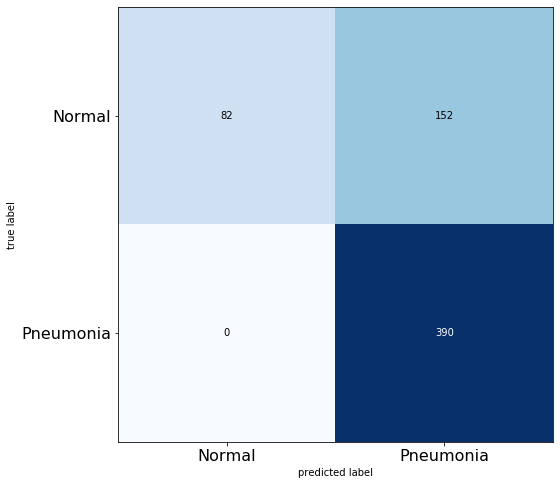

In [25]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [26]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.72
